In [1055]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By

import time
import sys
import numpy as np
import pandas as pd
import regex as re
import requests
import lxml
from lxml.html.soupparser import fromstring
import prettify
import numbers
import seaborn as sns
import time, os


import random
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

import folium
from folium.plugins import FastMarkerCluster
#https://peterhaas-me.medium.com/how-to-geocode-with-python-and-pandas-4cd1d717d3f7
#https://towardsdatascience.com/geocode-with-python-161ec1e62b89

import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


from datetime import datetime, timedelta

import sqlite3
import sqlalchemy

#set some display settings for notebooks
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [1056]:
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
chromedriver = os.path.expanduser(chromedriver)
print('chromedriver path: {}'.format(chromedriver))
sys.path.append(chromedriver)
driver = webdriver.Chrome(chromedriver)

chromedriver path: /Applications/chromedriver


## Scrape Housing Data

In [771]:
zillow_la_url = 'https://www.zillow.com/los-angeles-ca/sold/house,condo,multifamily,townhouse_type/1_p/'
zillow_la_url2 = 'https://www.zillow.com/los-angeles-ca/sold/house,condo,multifamily,townhouse_type/6_p/'
zillow_la_url3 = 'https://www.zillow.com/los-angeles-ca/sold/house,condo,multifamily,townhouse_type/11_p/'
zillow_la_url3 = 'https://www.zillow.com/santa-monica-ca/sold/house,condo,apartment_duplex,townhouse_type/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22usersSearchTerm%22%3A%22Santa%20Monica%2C%20CA%22%2C%22mapBounds%22%3A%7B%22west%22%3A-118.56100408500251%2C%22east%22%3A-118.42092840140876%2C%22south%22%3A33.9499771091641%2C%22north%22%3A34.03736423429407%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A26964%2C%22regionType%22%3A6%7D%5D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22pmf%22%3A%7B%22value%22%3Afalse%7D%2C%22pf%22%3A%7B%22value%22%3Afalse%7D%2C%22rs%22%3A%7B%22value%22%3Atrue%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22land%22%3A%7B%22value%22%3Afalse%7D%2C%22manu%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A13%7D'
zillow_la_url4 = 'https://www.zillow.com/homes/Inglewood,-CA_rb/'
zillow_la_url5 = 'https://www.zillow.com/downtown-los-angeles-ca/sold/'

In [782]:
def click_and_hold(element, driver=driver):
    ActionChains(driver).click_and_hold(element).perform()
    
def get_house_links(url, driver, pages=10):
    house_links=[]
    driver.get(url)
    for i in range(pages):
        try:
            driver.execute_script("window.scrollTo(0,4000);")
            time.sleep(3)
            driver.execute_script("window.scrollTo(0,8000);")
            time.sleep(3)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            listings = soup.find_all("a", class_='list-card-link')        
            page_data = [row['href'] for row in listings]
            house_links.append(page_data)
            time.sleep(np.random.lognormal(0,1))
            next_button = soup.find("a", title="Next page")
            next_url = next_button['href']
            next_button_link = 'https://www.zillow.com'+next_url
            if i<(pages-1):
                driver.get(next_button_link)
                print(next_button_link)
        except:
            captcha_field = driver.find_element(By.ID, "px-captcha")
            click_and_hold(captcha_field)
    return house_links

In [112]:
def get_html_data(url, driver):
    driver.get(url)
    time.sleep(np.random.lognormal(0,1))
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup


In [113]:
def get_price(soup): #fixed!
    try: 
        price = soup.find(class_='summary-container').find_all('span')[16].text
        price = price.replace(",", "").replace(":", "").replace("$", "").strip().lower()
        return int(price)
    except: 
        return np.nan
    
def get_sale_date(soup): #fixed!
    try:
        sale_date = soup.find(class_='summary-container').find_all('span')[17].text
        sale_date = sale_date.replace('Sold on', '').strip()        
        return sale_date
    except:
        return 'None'
    
def get_lot_size(soup): #fixed!
    try:
        lot_size = soup.find(class_='summary-container').find_all('span')[9].text
        lot_size = lot_size.replace("sqft", "").replace(',', '').strip().lower()
        return int(lot_size)
    except:
        return np.nan

def get_address(soup): #fixed!
    try:
        obj = soup.find("h1").text.replace('\xa0', ' ')
        return obj
    except:
        return 'None'

def get_num_beds(soup): #fixed!
    try: 
        num_beds = soup.find(class_='summary-container').find_all('span')[2].text
        return int(num_beds)
    except: 
        return np.nan
    
def get_num_baths(soup): #fixed!   
    try: 
        num_baths = soup.find(class_='summary-container').find_all('span')[6].text
        return int(num_baths)
    except: 
        return np.nan

def get_year_built(soup): #fixed!   
    try:
        year_built = soup.find("ul",class_='ds-home-fact-list').find_all('span')[3].text
        return int(year_built)
    except:
        return np.nan
    
def get_hoa(soup): #fixed!   
    try:
        hoa = soup.find("ul",class_='ds-home-fact-list').find_all('span')[-1].text
        hoa = hoa.replace('$', '').replace('monthly', '').strip()
        return int(hoa)
    except:
        return np.nan
    
def get_parking(soup): #fixed!   
    try:
        parking = soup.find("ul",class_='ds-home-fact-list').find_all('span')[9].text
        return parking
    except:
        return 'None'
    
def get_type(soup): #fixed!   
    try:
        type_ = soup.find("ul",class_='ds-home-fact-list').find_all('span')[1].text
        return type_
    except:
        return 'None'

In [114]:
def flatten_list(house_links):
    house_links_flat=[]
    for sublist in house_links:
        for item in sublist:
            if item in house_links_flat:
                continue
            house_links_flat.append(item)
    return house_links_flat

In [115]:
def get_house_data(driver,house_links_flat):
    house_data = []
    for link in house_links_flat:
        try:
            soup = get_html_data(link,driver)
            address = get_address(soup)
            beds = get_num_beds(soup)
            baths = get_num_baths(soup)
            lot_size = get_lot_size(soup)
            year_built = get_year_built(soup)
            sale_date = get_sale_date(soup)
            price = get_price(soup)
            hoa = get_hoa(soup)
            parking = get_parking(soup)
            type_ = get_type(soup)
            datapoint =  [address, price, lot_size, sale_date, beds, baths, year_built, hoa, parking, type_]
            print(datapoint)
            house_data.append([address, price, lot_size, sale_date, beds, baths, year_built, hoa, parking, type_])
        except:
            captcha_field = driver.find_element(By.ID, "px-captcha")
            click_and_hold(captcha_field)
        
    return house_data

#### Round 1

In [32]:
house_links_10pages = get_house_links(zillow_la_url,driver, 10)
house_links_flat = flatten_list(house_links_10pages)
house_data_10pages = get_house_data(driver,house_links_flat)

['1135 W 185th St, Gardena, CA 90248', 800000, 1866, '07/07/21', 3, 3, 1954, nan, '2 Attached Garage spaces', 'Single Family Residence']
['9631 Compton Ave, Los Angeles, CA 90002', 610000, 1522, '07/07/21', 4, 3, 2021, nan, '2 Attached Garage spaces', 'Single Family Residence']
['8701 Delgany Ave UNIT 304, Los Angeles, CA 90293', 1125000, 1785, '07/07/21', 3, 3, 1964, 460, '2 Garage spaces', 'Condominium']
['906 Parkman Ave, Los Angeles, CA 90026', 1455000, nan, '07/07/21', nan, nan, 1937, nan, 'Carport', 'Multi Family']
['7904 Topanga Canyon Blvd UNIT 7, Canoga Park, CA 91304', 542300, 1626, '07/07/21', 3, 3, 1981, nan, '3 Parking spaces', 'Townhouse']
['21917 Lopez St, Woodland Hills, CA 91364', 902000, 1014, '07/07/21', 3, 1, 1949, nan, 'No Data', 'Single Family Residence']
['18427 Vincennes St UNIT 6, Northridge, CA 91325', 514500, 1097, '07/07/21', 2, 2, 1984, 365, '4 Parking spaces', 'Condo']
['22326 Criswell St, Canoga Park, CA 91303', 1085000, 1500, '07/07/21', 3, 2, 1958, nan,

['850 Lucile Ave APT 7, Los Angeles, CA 90026', 810000, 1171, '07/02/21', 2, 2, 1984, nan, 'Garage', 'Townhouse']
['7533 Ashton Ct, Canoga Park, CA 91304', 1608000, 3857, '07/02/21', 5, 5, 1988, nan, '3 Attached Garage spaces', 'Single Family Residence']
['22938 Avenue San Luis, Woodland Hills, CA 91364', 977625, 2434, '07/02/21', 4, 3, 1990, nan, '2 Attached Garage spaces', 'Single Family Residence']
['3580 Alta Mesa Dr, Studio City, CA 91604', 2800000, 4019, '07/02/21', 5, 4, 1951, nan, 'Carport', 'Single Family Residence']
['4532 Don Milagro Dr, Los Angeles, CA 90008', 1070000, 2279, '07/02/21', 3, 3, 1959, nan, '2 Attached Garage spaces', 'Single Family Residence']
['12223 Inspire Ln, Pacoima, CA 91331', 615000, 1589, '07/02/21', 4, 3, 2012, nan, '2 Attached Garage spaces', 'Single Family Residence']
['16031 Harvest St, Granada Hills, CA 91344', 940000, 3020, '07/02/21', 5, 3, 1954, nan, '2 Attached Garage spaces', 'Single Family Residence']
['13182 Chesterwood St, Sylmar, CA 91342

['436 N Walker Ave, San Pedro, CA 90732', 730000, 1362, '06/30/21', 2, 1, 1930, nan, '1 Garage space', 'Single Family Residence']
['9821 Wilmington Ave, Los Angeles, CA 90002', 635000, nan, '06/30/21', nan, nan, 1929, nan, 'Driveway', 'Multi Family']
['1512 W 219th St, Torrance, CA 90501', 13122508, 2116, '06/30/21', 8, 4, 1948, nan, '2 Garage spaces', 'Quadruplex']
['None', nan, nan, 'None', nan, nan, nan, nan, 'None', 'None']
['None', nan, nan, 'None', nan, nan, nan, nan, 'None', 'None']


In [33]:
len(house_links_flat)

128

#### Round 2

In [81]:
house_links_10pages2 = get_house_links(zillow_la_url2,driver, 10)
house_links_flat2 = flatten_list(house_links_10pages2)
house_data_10pages2 = get_house_data(driver,house_links_flat2)

https://www.zillow.com/los-angeles-ca/sold/11_p/
https://www.zillow.com/los-angeles-ca/sold/12_p/
https://www.zillow.com/los-angeles-ca/sold/13_p/
https://www.zillow.com/los-angeles-ca/sold/14_p/
https://www.zillow.com/los-angeles-ca/sold/15_p/
https://www.zillow.com/los-angeles-ca/sold/16_p/
https://www.zillow.com/los-angeles-ca/sold/17_p/
https://www.zillow.com/los-angeles-ca/sold/18_p/
https://www.zillow.com/los-angeles-ca/sold/19_p/
['8325 Chase Ave, Los Angeles, CA 90045', 1770000, 1827, '06/30/21', 3, 2, 1946, nan, '2 Garage spaces', 'Single Family Residence']
['436 N Walker Ave, San Pedro, CA 90732', 730000, 1362, '06/30/21', 2, 1, 1930, nan, '1 Garage space', 'Single Family Residence']
['7937 Dunbarton Ave, Los Angeles, CA 90045', 1520000, 1459, '06/30/21', 3, 2, 1947, nan, 'Door-Multi, Garage', 'Single Family Residence']
['741 W 24th St APT 17, San Pedro, CA 90731', 455000, 900, '06/30/21', 2, 1, 1972, 331, '2 Garage spaces', 'Condominium']
['636 E 91st St, Los Angeles, CA 900

['1817 Selby Ave APT 402, Los Angeles, CA 90025', 1065000, 1468, '06/30/21', 2, 2, 1993, 550, 'Garage', 'Condominium']
['13440 Albers St, Van Nuys, CA 91401', 1305000, 1684, '06/30/21', 2, 2, 1954, nan, 'Door-Multi, Driveway, Garage', 'Single Family Residence']
['7033 La Tijera Blvd APT G101, Los Angeles, CA 90045', 433000, 566, '06/30/21', 1, 1, 1991, 375, '1 Garage space', 'Condominium']
['146 E 67th St, Los Angeles, CA 90003', nan, nan, 'None', nan, nan, nan, nan, 'Contact manager', 'Townhouse']
['1721 N Morton Ave, Los Angeles, CA 90026', 699000, 1844, '06/30/21', nan, nan, 1911, nan, 'No Data', 'Multi Family']
['10737 Tabor St, Los Angeles, CA 90034', 1275000, 1002, '06/30/21', 3, 2, 1924, nan, '2 Garage spaces', 'Single Family Residence']
['5101 Rubio Ave, Encino, CA 91436', 2710000, 4000, '06/30/21', 5, 6, 2016, nan, '2 Garage spaces', 'Single Family Residence']
['5257 Rainier Way, Valley Village, CA 91607', 1033960, 2089, '06/30/21', 4, 4, 2021, nan, '2 Attached Garage spaces',

['13420 Chase St, Pacoima, CA 91331', 805000, 1666, '06/29/21', 5, 3, 1964, nan, '2 Garage spaces', 'Single Family Residence']
['18730 Hatteras St UNIT 15, Tarzana, CA 91356', 892500, 1943, '06/29/21', 3, 3, 1985, nan, '2 Attached Garage spaces', 'Townhouse']
['1310 Laveta Ter, Los Angeles, CA 90026', 1250000, 2021, '06/29/21', 3, 3, 1927, nan, 'Driveway', 'Single Family Residence']
['17633 Nordhoff St, Northridge, CA 91325', 1000000, 2772, '06/29/21', 4, 4, 1961, nan, '2 Attached Garage spaces', 'Single Family Residence']
['12700 Otsego St, Valley Village, CA 91607', 1712500, 2852, '06/29/21', 5, 4, 1919, nan, 'Attached Garage', 'Single Family Residence']
['10108 Empyrean Way APT 103, Los Angeles, CA 90067', 2150000, 2019, '06/29/21', 2, 3, 1979, nan, 'Garage', 'Condominium']
['5020 Meridian St, Los Angeles, CA 90042', 1000000, 1302, '06/29/21', 3, 2, 1916, nan, '2 Garage spaces', 'Single Family Residence']
['3210 Barbee St, Los Angeles, CA 90031', 700000, 1956, '06/29/21', 4, 2, 1911

In [82]:
len(house_links_flat2)

146

#### Round 3

In [121]:
house_links_10pages3 = get_house_links(zillow_la_url3,driver, 10)
house_links_flat3 = flatten_list(house_links_10pages3)
house_data_10pages3 = get_house_data(driver,house_links_flat3)

https://www.zillow.com/santa-monica-ca/sold/house,condo,apartment_duplex,townhouse_type/2_p/
https://www.zillow.com/santa-monica-ca/sold/3_p/
https://www.zillow.com/santa-monica-ca/sold/4_p/
https://www.zillow.com/santa-monica-ca/sold/5_p/
https://www.zillow.com/santa-monica-ca/sold/6_p/
https://www.zillow.com/santa-monica-ca/sold/7_p/
https://www.zillow.com/santa-monica-ca/sold/8_p/
https://www.zillow.com/santa-monica-ca/sold/9_p/
https://www.zillow.com/santa-monica-ca/sold/10_p/
['840 20th St UNIT 10, Santa Monica, CA 90403', 1595000, 1555, '07/06/21', 3, 3, 1974, 450, 'Garage', 'Condominium']
['1244 12th St UNIT 6, Santa Monica, CA 90401', 1083000, 1265, '07/06/21', 2, 3, 1979, nan, '2 Garage spaces', 'Townhouse']
['2629 6th St, Santa Monica, CA 90405', 2615000, nan, '07/02/21', 3, 3, 1910, nan, 'Carport', 'Single Family Residence']
['1440 23rd St APT 113, Santa Monica, CA 90404', 747500, 970, '07/02/21', 2, 2, 1973, 395, '2 Garage spaces', 'Condominium']
['609 Washington Ave APT D,

['1002 S 8th Ave, Santa Monica, AZ 90405', 78000, 1249, '05/19/21', 2, 1, 1935, nan, '0 spaces', 'SingleFamily']
['2913 3rd St UNIT 405, Santa Monica, CA 90405', 2250000, 1532, '05/18/21', 2, 3, 1991, 617, '2 Garage spaces', 'Condominium']
['2314 28th St APT 1, Santa Monica, CA 90405', 860000, 999, '05/17/21', 2, 1, 1954, 384, 'Carport', 'Condominium']
['1824 20th St APT B, Santa Monica, CA 90404', 530000, 997, '05/17/21', 2, 1, 1963, 313, '0 spaces', 'Condo']
['2447 31st St, Santa Monica, CA 90405', 3505000, 2996, '05/17/21', 4, 5, 2018, nan, '1 Parking space', 'SingleFamily']
['930 California Ave UNIT 303, Santa Monica, CA 90403', 1410000, 1476, '05/17/21', 2, 2, 1974, 600, 'Garage', 'Condominium']
['123 Georgina Ave UNIT 11, Santa Monica, CA 90402', 2400000, 2671, '05/14/21', 2, 4, 1982, nan, '3 Attached Garage spaces', 'Townhouse']
['829 14th St UNIT 2, Santa Monica, CA 90403', 2110000, 2085, '05/14/21', 2, 4, 1979, 520, '2 Garage spaces', 'Condominium']
['629 Idaho Ave APT 2, Sant

['2348 29th St, Santa Monica, CA 90405', 2632000, 2852, '04/08/21', 4, 4, 1946, nan, '2 Garage spaces', 'Single Family Residence']
['1444 11th St #7, Santa Monica, CA 90401', 1339000, 1118, '04/08/21', 2, 2, 2020, 470, '2 Garage spaces', 'Condominium']
['832 Euclid St APT 109, Santa Monica, CA 90403', 687375, 700, '04/08/21', 1, 1, 1973, 320, '1 Garage space', 'Condominium']
['1035 25th St, Santa Monica, CA 90403', 2760000, 1501, '04/08/21', 3, 2, 1930, nan, '2 Attached Garage spaces', 'Single Family Residence']
['2455 23rd St, Santa Monica, CA 90405', 2100000, 1524, '04/08/21', 3, 2, 1937, nan, '2 Garage spaces', 'Single Family Residence']
['1420 Berkeley St, Santa Monica, CA 90404', 3000000, nan, '04/07/21', nan, nan, 1966, nan, 'Assigned, Covered, Driveway', 'Multi Family']
['129 Alta Ave UNIT 13, Santa Monica, CA 90402', 2290000, 1835, '04/07/21', 2, 2, 1976, nan, '2 Attached Garage spaces', 'Townhouse']
['835 Grant St #A, Santa Monica, CA 90405', 1415000, 1702, '04/05/21', 2, 3, 1

In [122]:
len(house_links_flat3)

170

#### Round 4

In [337]:
house_links_10pages4 = get_house_links(zillow_la_url4,driver, 3)
house_links_flat4 = flatten_list(house_links_10pages4)
house_data_10pages4 = get_house_data(driver,house_links_flat4)

https://www.zillow.com/inglewood-ca/sold/2_p/
https://www.zillow.com/inglewood-ca/sold/3_p/
['11000 Burin Ave, Inglewood, CA 90304', 515000, 392, '07/07/21', 1, 1, 1924, nan, 'No Data', 'Single Family Residence']
['1010 E Brett St, Inglewood, CA 90302', 893000, 1414, '07/07/21', 3, 2, 1931, nan, '2 Garage spaces', 'Single Family Residence']
['410 N Market St UNIT 22, Inglewood, CA 90302', 315000, 670, '07/06/21', 1, 1, 1962, 115, 'Assigned, Underground', 'Condominium']
['610 W Regent St APT 7, Inglewood, CA 90301', 469000, 988, '07/02/21', 2, 2, 1980, nan, 'Assigned', 'Townhouse']
['9702 S 7th Ave, Inglewood, CA 90305', 825000, 1399, '07/01/21', 3, 2, 1941, nan, 'Attached Garage', 'Single Family Residence']
['852 W Beach Ave UNIT 11, Inglewood, CA 90302', 400000, 973, '07/01/21', 2, 2, 1971, nan, 'Community Structure, Side By Side', 'Townhouse']
['520 E Ellis Ave, Inglewood, CA 90302', 1151000, 1330, '07/01/21', 2, 2, 2016, nan, '1 Garage space', 'Single Family Residence']
['4058 W 107

In [338]:
len(house_links_flat4)

54

#### Round 5

In [783]:
house_links_10pages5 = get_house_links(zillow_la_url5,driver, 3)
house_links_flat5 = flatten_list(house_links_10pages5)
house_data_10pages5 = get_house_data(driver,house_links_flat5)

https://www.zillow.com/downtown-los-angeles-ca/sold/2_p/
https://www.zillow.com/downtown-los-angeles-ca/sold/3_p/
['460 S Spring St APT 416, Los Angeles, CA 90013', 549000, 900, '07/07/21', 1, 1, 1912, 640, 'Carport', 'Condominium']
['655 S Hope St UNIT 903, Los Angeles, CA 90017', 389000, 600, '07/07/21', 1, 1, 1964, 712, 'Garage', 'Condominium']
['1155 S Grand Ave APT 602, Los Angeles, CA 90015', 615000, 1090, '07/07/21', nan, 2, 2008, 871, 'Assigned, Controlled Entrance, Covered, Underground', 'Condominium']
['1100 S Hope St APT 1904, Los Angeles, CA 90015', 5000000, 3400, '07/06/21', 3, 4, 2007, nan, 'None', 'Condo']
['939 S Broadway #B3, Los Angeles, CA 90015', 469000, 849, '07/01/21', 2, 1, 1925, 549, 'On Street', 'Condominium']
['215 W 7th St APT 709, Los Angeles, CA 90014', 328000, 460, '07/01/21', nan, 1, 1911, 493, 'None', 'Condominium']
['1155 S Grand Ave APT 715, Los Angeles, CA 90015', 535000, 900, '06/30/21', 1, 1, 2008, 856, '1 Attached Garage space', 'Condominium']
['10

In [826]:
house_data = house_data_10pages + house_data_10pages2 + house_data_10pages3 + house_data_10pages4 + house_data_10pages5

In [1009]:
columns = ["address", 'price', 'sq_ft', 'date_sold', 'beds', 'baths', 'year_built', 'hoa', 'parking', 'type_']
#, "city", "zip", "bedrooms", "bathrooms", "floor_size", "lot_size", "year_built", "sale_date", "sale_price"]
df = pd.DataFrame(house_data, columns = columns)

In [1010]:
df.shape

(698, 10)

In [1011]:
df = df.drop_duplicates(subset='address')
df.shape

(537, 10)

In [1012]:
df

,address,price,sq_ft,date_sold,beds,baths,year_built,hoa,parking,type_
0,"1135 W 185th St, Gardena, CA 90248",800000.0,1866.0,07/07/21,3.0,3.0,1954.0,NaN,2 Attached Garage spaces,Single Family Residence
1,"9631 Compton Ave, Los Angeles, CA 90002",610000.0,1522.0,07/07/21,4.0,3.0,2021.0,NaN,2 Attached Garage spaces,Single Family Residence
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 90293",1125000.0,1785.0,07/07/21,3.0,3.0,1964.0,460.0,2 Garage spaces,Condominium
3,"906 Parkman Ave, Los Angeles, CA 90026",1455000.0,NaN,07/07/21,NaN,NaN,1937.0,NaN,Carport,Multi Family
4,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",542300.0,1626.0,07/07/21,3.0,3.0,1981.0,NaN,3 Parking spaces,Townhouse
...,...,...,...,...,...,...,...,...,...,...
684,"600 W 9th St APT 114, Los Angeles, CA 90015",760000.0,1193.0,05/19/21,2.0,2.0,1983.0,854.0,"Assigned, Controlled Entrance, Community Struc...",Condominium
685,"901 S Flower St UNIT 700, Los Angeles, CA 90015",1050000.0,1570.0,05/18/21,2.0,2.0,2009.0,350.0,0 spaces,Condo
686,"901 S Flower St #700, Los Angeles, CA 90015",NaN,NaN,None,NaN,NaN,NaN,NaN,No Pets,Sat Jul 10 2021
687,"1155 S Grand Ave APT 422, Los Angeles, CA 90015",880000.0,1490.0,05/18/21,2.0,2.0,2008.0,880.0,0 spaces,Condominium


## Clean Housing Data

In [1013]:
df = df[df['address'] != 'None']
df.shape

(536, 10)

In [1014]:
df= df[df.price.notnull()]
df.shape

(524, 10)

In [1015]:
df.describe()

,price,sq_ft,beds,baths,year_built,hoa
count,5.240000e+02,482.000000,473.000000,475.000000,516.000000,148.000000
mean,1.492751e+06,1816.182573,2.782241,2.515789,1966.393411,485.540541
std,1.708505e+06,1241.351997,1.245816,1.349036,30.593899,201.654260
min,2.000000e+03,230.000000,1.000000,1.000000,1812.000000,115.000000
25%,6.867812e+05,1072.500000,2.000000,2.000000,1947.750000,324.000000
50%,1.000000e+06,1479.000000,3.000000,2.000000,1964.000000,425.000000
75%,1.700688e+06,2079.500000,4.000000,3.000000,1986.000000,610.500000
max,1.470000e+07,11972.000000,8.000000,9.000000,2021.000000,975.000000


In [1016]:
no_parking = ['No Data', '0 spaces', 'None', 'On Street']
df['has_parking'] = df['parking'].apply(lambda x: 0 if x in no_parking else 1)

In [1017]:
df.type_.value_counts()

Single Family Residence    237
Condominium                141
Townhouse                   48
Multi Family                40
Condo                       26
SingleFamily                16
Triplex                      3
Apartment                    3
Manufactured Home            3
Duplex                       2
Quadruplex                   2
Unknown                      1
Stock Cooperative            1
MultiFamily                  1
Name: type_, dtype: int64

In [1018]:
df = df[~df.type_.isin(['Multi Family', 'Triplex', 'Manufactured Home', 'Duplex', 'Quadruplex', 'Stock Cooperative', 'MultiFamily', 'Unknown'])]

In [1019]:
is_condo = ['Condominium', 'Condo', 'Apartment']
is_sfr = ['Single Family Residence', 'SingleFamily']
is_townhouse = ['Townhouse']

In [1020]:
df['is_condo'] = df['type_'].apply(lambda x: 1 if x in is_condo else 0)
df['is_sfr'] = df['type_'].apply(lambda x: 1 if x in is_sfr else 0)
df['is_townhouse'] = df['type_'].apply(lambda x: 1 if x in is_townhouse else 0)

In [1021]:
df['date_sold'] = pd.to_datetime(df['date_sold'])

In [1022]:
df['years_old'] = 2021 - df['year_built']

In [1023]:
month_cutoff = datetime.now() - timedelta(days = 30)
df = df[df.date_sold > month_cutoff]
df.shape

(295, 15)

In [1024]:
df_copy = df.copy()
df = df.drop(['date_sold', 'year_built', 'parking', 'type_'], axis=1)
df

,address,price,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old
0,"1135 W 185th St, Gardena, CA 90248",800000.0,1866.0,3.0,3.0,NaN,1,0,1,0,67.0
1,"9631 Compton Ave, Los Angeles, CA 90002",610000.0,1522.0,4.0,3.0,NaN,1,0,1,0,0.0
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 90293",1125000.0,1785.0,3.0,3.0,460.0,1,1,0,0,57.0
4,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",542300.0,1626.0,3.0,3.0,NaN,1,0,0,1,40.0
5,"21917 Lopez St, Woodland Hills, CA 91364",902000.0,1014.0,3.0,1.0,NaN,0,0,1,0,72.0
6,"18427 Vincennes St UNIT 6, Northridge, CA 91325",514500.0,1097.0,2.0,2.0,365.0,1,1,0,0,37.0
7,"22326 Criswell St, Canoga Park, CA 91303",1085000.0,1500.0,3.0,2.0,NaN,1,0,1,0,63.0
8,"5301 Rainier Way, Valley Village, CA 91607",814230.0,1192.0,2.0,3.0,NaN,1,0,1,0,0.0
9,"11064 Charnock Rd, Los Angeles, CA 90034",1500000.0,3285.0,7.0,3.0,NaN,1,0,1,0,110.0
10,"4358 Mammoth Ave APT 17, Sherman Oaks, CA 91423",440000.0,815.0,1.0,1.0,270.0,1,1,0,0,61.0


In [1025]:
df.hoa.fillna(0, inplace=True)
df.loc[46, 'years_old'] = 2
df[df.years_old.isnull()]

,address,price,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old


In [1026]:
df.isnull().sum()

address         0
price           0
sq_ft           3
beds            2
baths           0
hoa             0
has_parking     0
is_condo        0
is_sfr          0
is_townhouse    0
years_old       0
dtype: int64

In [1027]:
df[df.beds.isnull()]

,address,price,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old
646,"1155 S Grand Ave APT 602, Los Angeles, CA 90015",615000.0,1090.0,NaN,2.0,871.0,1,1,0,0,13.0
649,"215 W 7th St APT 709, Los Angeles, CA 90014",328000.0,460.0,NaN,1.0,493.0,0,1,0,0,110.0


In [1028]:
#drop rows missing both bed and bath counts
df.dropna(subset=['beds', 'baths'], how='all', axis=0, inplace=True)

In [1029]:
df.beds.fillna(0, inplace=True)

In [1030]:
df.isnull().sum()

address         0
price           0
sq_ft           3
beds            0
baths           0
hoa             0
has_parking     0
is_condo        0
is_sfr          0
is_townhouse    0
years_old       0
dtype: int64

In [1031]:
df.dropna(subset=['sq_ft'], how='all', axis=0, inplace=True)
df[df.sq_ft.isnull()]
df.shape

(292, 11)

In [1032]:
#move `price` column to the end of dataframe 
df= df[[c for c in df if c not in ['price']] + ['price']]

In [988]:
connection = sqlite3.connect('Housing_Linear_Reg.db')
df.to_sql('housing_data', connection, index=False)

#can call this cleaned data as needed by uncommenting below
'''engine = create_engine("sqlite:///linear_reg.db")
df = pd.read_sql('SELECT * FROM house_data;', engine)'''

'engine = create_engine("sqlite:///linear_reg.db")\ndf = pd.read_sql(\'SELECT * FROM house_data;\', engine)'

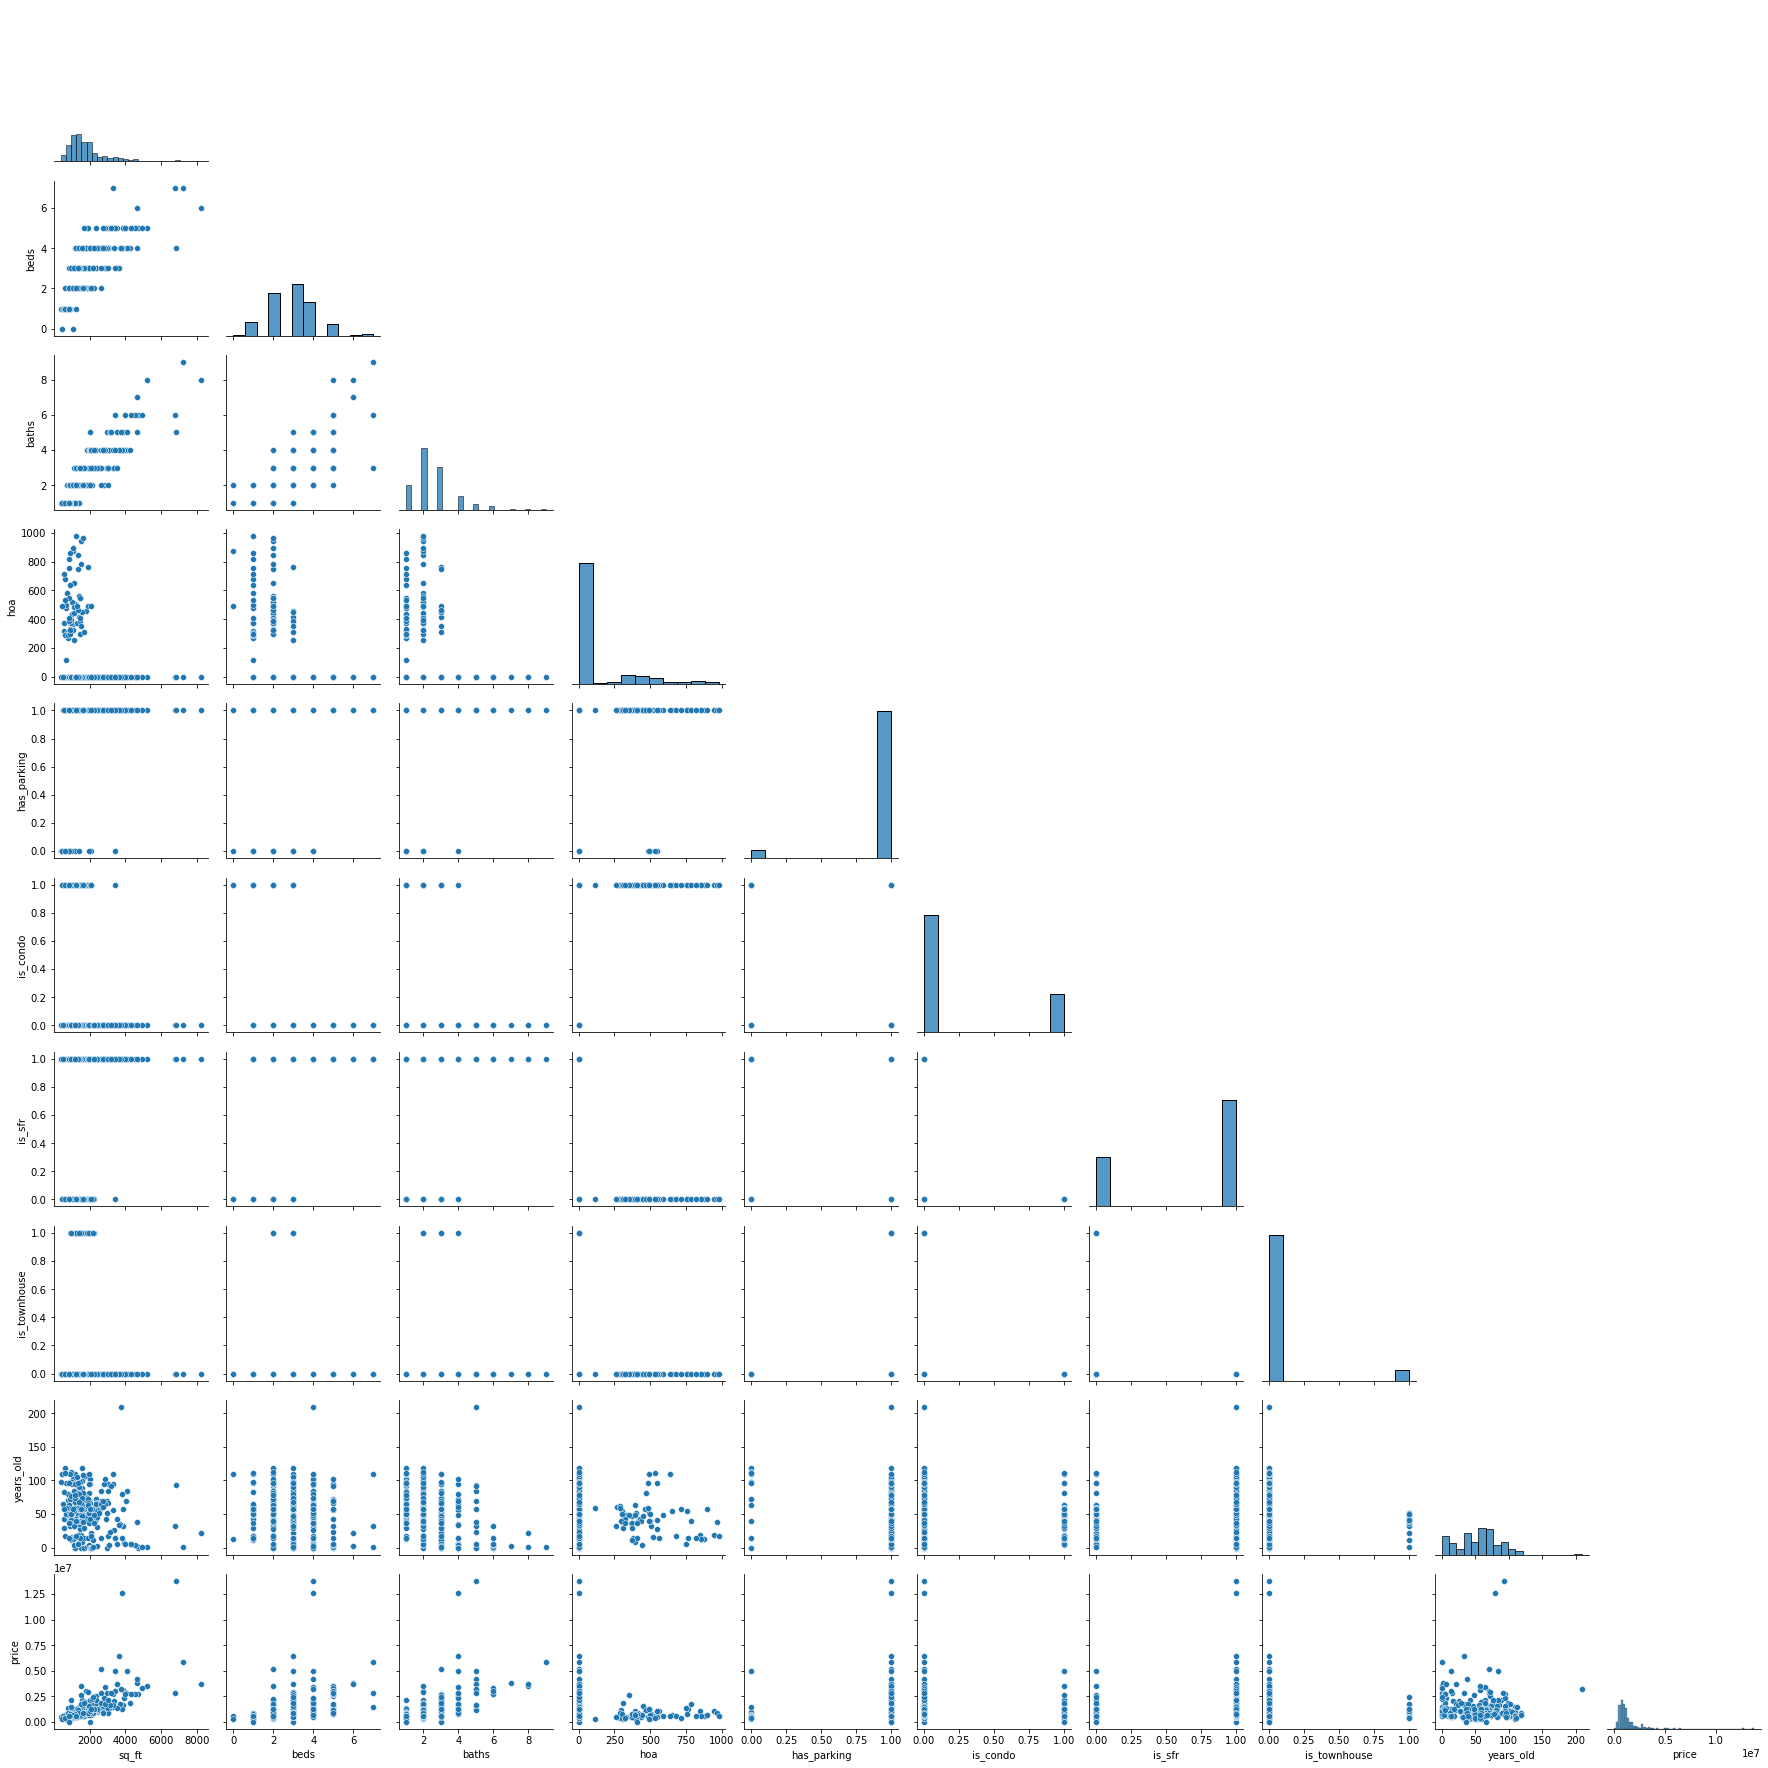

In [1033]:
sns.pairplot(df, corner=True);

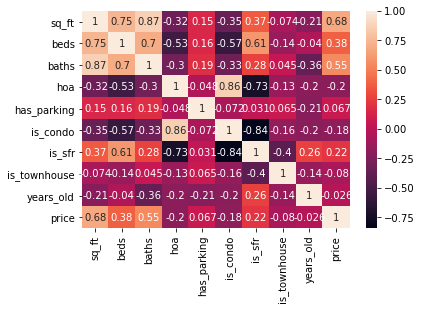

In [990]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True);

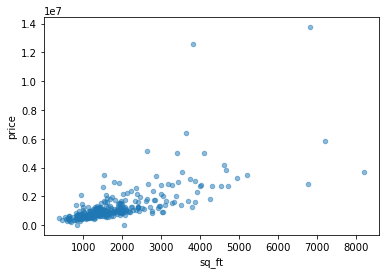

In [995]:
df.plot('sq_ft', 'price', kind='scatter', alpha=0.5);

## Run First Linear Model

In [1082]:
df.shape

(292, 12)

In [1086]:
df.to_pickle("housing_data.pkl") 

In [1]:
df_X = df.drop(['address', 'price'], axis =1)
df_y = df['price']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('Train: ', lr.score(X_train,y_train))
print('Val: ', lr.score(X_val,y_val))

SyntaxError: invalid syntax (<ipython-input-1-2cb6d249aa2e>, line 12)

## Scraping Geographic Data

In [1041]:
#https://stats.stackexchange.com/questions/94902/how-to-represent-geography-or-zip-code-in-machine-learning-model-or-recommender
df['address'] = df['address'] + ', USA'
zip_codes = list(df.address.str[-10:].unique())

In [1057]:
def get_html_data(url, driver):
    driver.get(url)
    time.sleep(np.random.lognormal(0,1))
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup

def get_med_resident_age(soup): #fixed!
    try: 
        age_string = soup.find_all('div', class_='hgraph')[3].text.split(':')[2]
        age = age_string.replace('years', '').replace('California median age','').strip()
        return float(age)
    except: 
        return np.nan

def get_avg_household_size(soup):
    try:
        household_string = soup.find_all('div', class_='hgraph')[4].text.split(':')[2] 
        household_size = household_string.replace('people', '').replace('California', '').strip()
        return float(household_size)
    except: 
        return np.nan
    
def get_med_household_income(soup):
    try:
        household_string = driver.find_element(By.XPATH, '//*[@id="body"]/div[19]/table/tbody/tr[1]/td[2]').text
        household_income = household_string.replace('$','').replace(',','').strip()
        return int(household_income)
    except: 
        return np.nan
    
def get_pct_poverty(soup):
    try:
        pct_poverty_string = driver.find_element(By.XPATH, '//*[@id="body"]/div[22]/table/tbody/tr[1]/td[2]').text
        pct_poverty = pct_poverty_string.replace('%','').strip()
        return float(pct_poverty)
    except: 
        return np.nan
    
def get_pct_bachelors(soup):
    try:
        bachelors = soup.find(text='High school or higher:').findNext().contents[1]
        bachelors = bachelors.replace('%', '')
        return float(bachelors)
    except: 
        return np.nan

In [1058]:
def get_zip_data(driver,zip_codes):
    zip_data = []
    for zip_code in zip_codes:
        zip_code = zip_code[:5]
        url = 'http://www.city-data.com/zips/{}.html'.format(zip_code)
        soup = get_html_data(url,driver)
        median_age = get_med_resident_age(soup)
        avg_household = get_avg_household_size(soup)
        median_income = get_med_household_income(soup)
        pct_poverty = get_pct_poverty(soup)
        pct_bachelors = get_pct_bachelors(soup)
        datapoint = [zip_code, median_age, avg_household, median_income, pct_poverty, pct_bachelors, url]
        print(datapoint)
        zip_data.append(datapoint)
        
    return zip_data

In [1059]:
driver.get('http://www.city-data.com/zips/90002.html')
soup = BeautifulSoup(driver.page_source, 'html.parser')

zip_data = get_zip_data(driver, zip_codes)

['90248', 43.5, 3.0, 64253, 9.7, 27.9, 'http://www.city-data.com/zips/90248.html']
['90002', 28.3, 4.1, 38987, 28.8, 6.1, 'http://www.city-data.com/zips/90002.html']
['90293', 38.3, 1.9, 110698, 5.8, 74.7, 'http://www.city-data.com/zips/90293.html']
['91304', 38.7, 3.1, 73724, 11.7, 31.5, 'http://www.city-data.com/zips/91304.html']
['91364', 44.1, 2.6, 111075, 5.5, 55.5, 'http://www.city-data.com/zips/91364.html']
['91325', 37.3, 2.9, 74660, 13.6, 40.2, 'http://www.city-data.com/zips/91325.html']
['91303', 32.5, 3.1, 64046, 15.7, 24.7, 'http://www.city-data.com/zips/91303.html']
['91607', 39.6, 2.2, 74964, 9.4, 50.4, 'http://www.city-data.com/zips/91607.html']
['90034', 34.4, 2.1, 79171, 9.0, 59.2, 'http://www.city-data.com/zips/90034.html']
['91423', 39.0, 2.2, 95082, 7.1, 62.0, 'http://www.city-data.com/zips/91423.html']
['90032', 34.4, 3.4, 59838, 17.8, 20.8, 'http://www.city-data.com/zips/90032.html']
['90026', 35.1, 2.6, 68249, 17.2, 41.6, 'http://www.city-data.com/zips/90026.html

In [1060]:
zip_columns = ['zip_code', 'median_age', 'avg_household', 'median_income', 'pct_poverty', 'pct_bachelors', 'url']
zip_df = pd.DataFrame(zip_data, columns = zip_columns)
zip_df

,zip_code,median_age,avg_household,median_income,pct_poverty,pct_bachelors,url
0,90248,43.5,3.0,64253.0,9.7,27.9,http://www.city-data.com/zips/90248.html
1,90002,28.3,4.1,38987.0,28.8,6.1,http://www.city-data.com/zips/90002.html
2,90293,38.3,1.9,110698.0,5.8,74.7,http://www.city-data.com/zips/90293.html
3,91304,38.7,3.1,73724.0,11.7,31.5,http://www.city-data.com/zips/91304.html
4,91364,44.1,2.6,111075.0,5.5,55.5,http://www.city-data.com/zips/91364.html
5,91325,37.3,2.9,74660.0,13.6,40.2,http://www.city-data.com/zips/91325.html
6,91303,32.5,3.1,64046.0,15.7,24.7,http://www.city-data.com/zips/91303.html
7,91607,39.6,2.2,74964.0,9.4,50.4,http://www.city-data.com/zips/91607.html
8,90034,34.4,2.1,79171.0,9.0,59.2,http://www.city-data.com/zips/90034.html
9,91423,39.0,2.2,95082.0,7.1,62.0,http://www.city-data.com/zips/91423.html


In [1061]:
%%capture

geolocator=Nominatim(user_agent='myGeocoder')
zip_df['zip_usa'] = zip_df['zip_code'] + ', USA'
zip_df['gcode'] = zip_df.zip_usa.apply(geolocator.geocode)
zip_df['lat'] = [g.latitude for g in zip_df.gcode]
zip_df['long'] = [g.longitude for g in zip_df.gcode]

In [1090]:
zip_df.loc[87, 'median_income'] = 54400.0
zip_df.loc[90, 'median_income'] = 54400.0
zip_df.loc[52, 'median_income'] = 119658.0
zip_df.loc[52, 'pct_poverty'] = 7.4

In [1092]:
zip_df.to_pickle("zip_data.pkl")

## Visualize Distribution of Homes

In [1079]:
df_merged = pd.merge(left=df, right=zip_df, how='left', left_on='zip_code', right_on='zip_code')

In [1080]:
df_merged.head()

,address,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old,price,zip_code,median_age,avg_household,median_income,pct_poverty,pct_bachelors,url,zip_usa,gcode,lat,long
0,"1135 W 185th St, Gardena, CA 90248, USA",1866.0,3.0,3.0,0.0,1,0,1,0,67.0,800000.0,90248,43.5,3.0,64253.0,9.7,27.9,http://www.city-data.com/zips/90248.html,"90248, USA","(Harbor Gateway, California, 90248, United Sta...",33.881499,-118.284065
1,"9631 Compton Ave, Los Angeles, CA 90002, USA",1522.0,4.0,3.0,0.0,1,0,1,0,0.0,610000.0,90002,28.3,4.1,38987.0,28.8,6.1,http://www.city-data.com/zips/90002.html,"90002, USA","(Florence-Firestone, Firestone Park, Californi...",33.954675,-118.248034
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 902...",1785.0,3.0,3.0,460.0,1,1,0,0,57.0,1125000.0,90293,38.3,1.9,110698.0,5.8,74.7,http://www.city-data.com/zips/90293.html,"90293, USA","(Playa del Rey, Los Angeles, California, 90293...",33.959733,-118.438432
3,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",1626.0,3.0,3.0,0.0,1,0,0,1,40.0,542300.0,91304,38.7,3.1,73724.0,11.7,31.5,http://www.city-data.com/zips/91304.html,"91304, USA","(Los Angeles, California, 91304, United States...",34.218093,-118.614535
4,"21917 Lopez St, Woodland Hills, CA 91364, USA",1014.0,3.0,1.0,0.0,0,0,1,0,72.0,902000.0,91364,44.1,2.6,111075.0,5.5,55.5,http://www.city-data.com/zips/91364.html,"91364, USA","(Los Angeles, California, 91364, United States...",34.165288,-118.610120


In [1081]:
df_merged.to_pickle("housing_zip.pkl")